# CMA-ES
All the ES variants so far mutate isotropically — z ~ N(0, I), a perfect sphere. Every direction is equally likely. This works fine when the fitness landscape happens to be round and axis-aligned. But real problems rarely are.
Imagine a thin diagonal valley. The optimum lies along a direction that's a mixture of x₁ and x₂. Isotropic mutation wastes most of its attempts stepping across the valley walls instead of along the floor. What you want is a mutation ellipsoid that's stretched along the valley and compressed across it — and you want the algorithm to learn this shape from experience.

#Q why are isotropic mutations inefficient in some solution spaces? because isotropic mutation samples equally in all directions, but ill-conditioned or rotated landscapes have very different scales and orientations across dimensions — most sampled directions will be wasteful.


### Correlated mutations 
We replace N(0, I) with a full covariance matrix C:

x′ = x + σ · N(0, C)    

C encodes both the preferred directions (eigenvectors) and the relative scales (eigenvalues) of successful mutations. It starts as the identity (isotropic) and gets shaped over time to match the fitness landscape. Since C is symmetric positive definite, we decompose it as C = AAᵀ (Cholesky), then sample as x′ = x + σ·A·z where z ~ N(0,I).

#Q What does C actually encode? The directions and scales of recent successful steps. If offspring consistently improve along a particular diagonal direction, C learns to stretch mutations in that direction.

### Simple CMA-ES 
Maintain a mean x̄, global step size σ, and covariance matrix C. Each generation:
1. Sample λ offspring from N(x̄, σ²C)
2. Select best µ individuals
3. Update mean: x̄ = (1/µ) Σ x(i)
4. Update covariance (rank-µ update):

                     C ← (1 − cµ)C + cµ · (1/µ) Σᵢ (x(i) − x̄)(x(i) − x̄)ᵀ

This says: forget a bit of the old C, and add the empirical covariance of the selected offspring. Over time, C converges to reflect the shape of the fitness landscape in the region being searched.
- Adapt σ using Rechenberg's rule on mean improvement (eq. 6 variant with τ = 1/√(n+1))

### Rank-µ vs Rank-1 update
Both updates shape C, but they use different sources of information.

Rank-µ update looks at the current generation's selected offspring. After selecting the best µ individuals, we ask: where did the good solutions cluster relative to the mean? We compute the empirical covariance of those µ winners:

C ← (1 − cµ)C + cµ · (1/µ) Σᵢ (x(i) − x̄)(x(i) − x̄)ᵀ

Each (x(i) − x̄)(x(i) − x̄)ᵀ is a rank-1 matrix (a single outer product). We're summing µ of them — hence rank-µ. It's called that because you're updating C with information from µ points simultaneously. This is fast to respond — it reshapes C based on what just worked — but it only sees one generation at a time.

Rank-1 update instead uses the evolution path pc — the accumulated history of where the algorithm has been moving across many generations. It adds c1·pc·pcᵀ to C, which is a single outer product (rank-1). This slowly reinforces whatever direction the algorithm has been consistently stepping in over time.

#Q Why is the rank-1 term "slow but valuable"? Because pc accumulates over many generations, it captures a direction that has been repeatedly successful — not just lucky once. The rank-µ term can be fooled by one generation of fortunate draws; the rank-1 term can't, because it reflects a long-term trend.

So intuitively: 
- rank-µ gives C its rough shape quickly from current offspring (faster, but only sees the current generation)
- rank-1 refines it gradually using long-term directional memory (Slow but captures long-range directional trends). Together they make C both responsive and stable.

#Q Why is CMA-ES so powerful? Because it learns the full geometry of the problem — not just "should I step bigger or smaller" (Rechenberg) or "which dimensions need different scales" (self-adaptation), but the actual correlation structure between dimensions. A diagonal valley at 45° is invisible to per-dimension σ adaptation but trivial for CMA-ES.

### Conceptual Questions 
- Why are isotropic mutations inefficient in some solution spaces?
- What does the covariance matrix C encode?
- Explain the rank-µ update of the CMA-ES.

### Manual Simulation Questions 
- Given x = [2,1] and C=[(2,1)(1,2)] and σ = 0.5, compute one mutation using z ∼N(0,I)
- From offspring x1 = [1,2], x2 = [1.5,2.5], x3 = [0.5,1.5], compute x and the empirical covariance.

In [1]:
pip install cma -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cma

# ----- Benchmark functions -----

def sphere(x):
    return np.sum(x**2)

def rastrigin(x):
    x = np.array(x)
    return 10*len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x))

In [3]:
def one_plus_one_es_classic(fitness_function, N=10, sigma=0.5, max_generations=1000):
    x = np.random.uniform(-5, 5, N)
    history = []

    for _ in range(max_generations):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        print(fitness_function(x))
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
        history.append(fitness_function(x))
        sigma*=0.99

    return x, history


for f in [sphere]:
    x_best, history = one_plus_one_es_classic(f)
    print(f.__name__, "Best fitness:", history[-1])

68.41248841632651
68.41248841632651
65.20851361387803
65.20851361387803
65.20851361387803
65.20851361387803
65.20851361387803
65.20851361387803
61.48179824602275
59.49478838196794
59.49478838196794
59.49478838196794
57.64819689754093
50.92698261853494
50.92698261853494
50.92698261853494
48.07489285726448
48.07489285726448
48.07489285726448
48.07489285726448
37.76583781881187
37.76583781881187
34.36081753862117
28.750337597600275
28.750337597600275
28.667919646737285
27.854329810242223
24.789845460779777
24.789845460779777
24.789845460779777
23.836313707492234
16.10125867245359
11.376762523537524
11.376762523537524
11.376762523537524
11.376762523537524
8.714159239313439
8.714159239313439
8.714159239313439
6.025087622651782
6.025087622651782
6.025087622651782
6.025087622651782
6.025087622651782
6.025087622651782
6.025087622651782
6.025087622651782
5.113001957869545
3.588782612573503
3.199332326636862
1.6016058385569267
1.6016058385569267
1.6016058385569267
1.6016058385569267
1.6016058385

In [4]:
def one_plus_one_es_success_rule(fitness_function, N=10, sigma=0.5, max_generations=2000):
    x = np.random.uniform(-5, 5, N)
    tau = 1.5
    k = 20
    success_count = 0
    history = []

    for t in range(1, max_generations + 1):
        x_prime = x + sigma * np.random.normal(0, 1, N)
        if fitness_function(x_prime) <= fitness_function(x):
            x = x_prime
            success_count += 1

        if t % k == 0:
            success_rate = success_count / k
            if success_rate > 1/5:
                sigma *= tau
            else:
                sigma /= tau
            success_count = 0

        history.append(fitness_function(x))

    return x, history


for f in [sphere, rastrigin]:
    x_best, history = one_plus_one_es_success_rule(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 6.282719758995677e-24
rastrigin Best fitness: 76.61135131334035


In [5]:
def mu_plus_lambda_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200, sigma=0.3):
    population = np.random.randn(mu, dim)
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            parent = population[np.random.randint(mu)]
            child = parent + sigma * np.random.randn(dim)
            offspring.append(child)

        combined = np.vstack([population, offspring])
        fitness = np.array([fitness_fn(ind) for ind in combined])
        best_indices = np.argsort(fitness)[:mu]
        population = combined[best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = mu_plus_lambda_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.07112650232597721
rastrigin Best fitness: 16.636560498187848


In [6]:
def self_adaptive_es(fitness_fn, dim=10, mu=5, lmbda=20, generations=200):
    tau = 1 / np.sqrt(dim)
    population = [(np.random.randn(dim), 0.5) for _ in range(mu)]
    history = []

    for _ in range(generations):
        offspring = []
        for _ in range(lmbda):
            x, sigma = population[np.random.randint(mu)]
            sigma_prime = sigma * np.exp(tau * np.random.randn())
            sigma_prime = max(sigma_prime, 1e-8)
            x_prime = x + sigma_prime * np.random.randn(dim)
            offspring.append((x_prime, sigma_prime))

        combined = population + offspring
        fitness = [fitness_fn(ind[0]) for ind in combined]
        best_indices = np.argsort(fitness)[:mu]
        population = [combined[i] for i in best_indices]
        history.append(fitness[best_indices[0]])

    return population[0], history


for f in [sphere, rastrigin]:
    best, history = self_adaptive_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 3.0966095463640783e-15
rastrigin Best fitness: 14.924370742942216


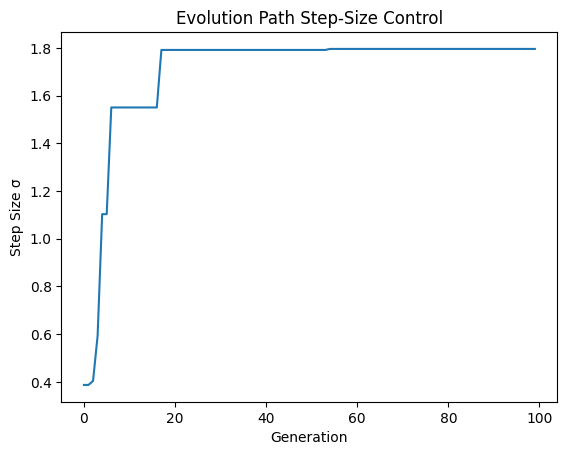

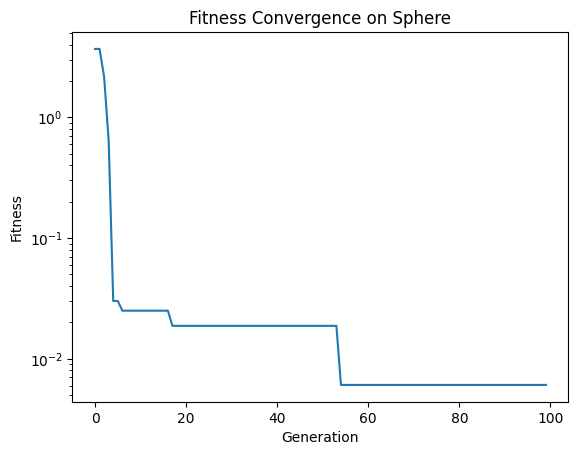

In [7]:
def evolution_path_es(generations=100):
    x = 2.0
    sigma = 0.5
    p_sigma = 0.0
    c_sigma = 0.3
    d_sigma = 1.0
    expected_norm = np.sqrt(2/np.pi)

    sigma_vals = []
    fitness_vals = []

    for _ in range(generations):
        z = np.random.randn()
        x_candidate = x + sigma * z

        # Elitist selection
        if sphere(x_candidate) < sphere(x):
            x = x_candidate
            p_sigma = (1 - c_sigma) * p_sigma + np.sqrt(c_sigma*(2-c_sigma)) * z
            sigma *= np.exp((c_sigma/d_sigma) * (abs(p_sigma)/expected_norm - 1))

        sigma_vals.append(sigma)
        fitness_vals.append(sphere(x))

    return sigma_vals, fitness_vals

sigma_vals, fitness_vals = evolution_path_es()

# Plot step size
plt.figure()
plt.plot(sigma_vals)
plt.xlabel("Generation")
plt.ylabel("Step Size σ")
plt.title("Evolution Path Step-Size Control")
plt.show()

# Plot fitness (log scale)
plt.figure()
plt.plot(fitness_vals)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.yscale("log")
plt.title("Fitness Convergence on Sphere")
plt.show()

In [8]:
def simple_cma_es(fitness_fn, N=10, sigma=0.5, lambda_=10, mu=5, generations=200):
    x = np.random.randn(N)
    C = np.eye(N)
    history = []

    for _ in range(generations):
        A = np.linalg.cholesky(C)
        Z = np.random.randn(lambda_, N)
        X = x + sigma * Z @ A.T
        fitnesses = np.array([fitness_fn(xi) for xi in X])
        indices = np.argsort(fitnesses)
        selected = X[indices[:mu]]
        x_mean = np.mean(selected, axis=0)

        C_update = np.zeros((N,N))
        for xi in selected:
            diff = xi - x_mean
            C_update += np.outer(diff, diff)
        C = 0.8*C + 0.2*(C_update/mu)

        if fitness_fn(x_mean) <= fitness_fn(x):
            x = x_mean

        history.append(fitness_fn(x))

    return x, history


for f in [sphere, rastrigin]:
    best, history = simple_cma_es(f)
    print(f.__name__, "Best fitness:", history[-1])

sphere Best fitness: 0.00907551181211826
rastrigin Best fitness: 12.934457666574644


In [9]:
def run_pycma(fitness_fn):
    N = 10
    initial_mean = np.random.randn(N)
    initial_sigma = 0.5

    es = cma.CMAEvolutionStrategy(initial_mean, initial_sigma)
    es.optimize(fitness_fn, maxfun=10000)
    print("Best fitness:", es.result.fbest)

print("Sphere:")
run_pycma(sphere)

print("\nRastrigin:")
run_pycma(rastrigin)

Sphere:
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=221834, Fri Feb 27 12:02:22 2026)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 4.560531051591264e+00 1.0e+00 4.99e-01  5e-01  5e-01 0:00.0
    2     20 2.965250447264911e+00 1.2e+00 4.97e-01  5e-01  5e-01 0:00.0
    3     30 1.584402548576211e+00 1.3e+00 5.49e-01  5e-01  6e-01 0:00.0
  100   1000 3.937488794846348e-07 1.8e+00 5.31e-04  2e-04  2e-04 0:00.0
  200   2000 1.230621979403281e-13 1.9e+00 8.19e-07  1e-07  2e-07 0:00.1
  206   2060 4.198340533372444e-14 2.0e+00 5.82e-07  8e-08  1e-07 0:00.1
termination on {'tolfun': 1e-11}
final/bestever f-value = 4.198341e-14 4.198341e-14 after 2060/2059 evaluations
incumbent solution: [ 3.17970095e-08  1.00553797e-08 -1.34790645e-07  1.19046073e-08
  4.65142326e-08 -4.52554633e-08  1.01733916e-07 -5.34813695e-08 ...]
std deviations: [1.00372161e-07 9.53924018e-08 8.18928805e-08 8.67414589e-08
 9.91953788e-08 9.29124466e-08 9.50623994e-08 

# EXERCISES 3 (a)(b)

# Particle Swarm Optimisation (PSO)

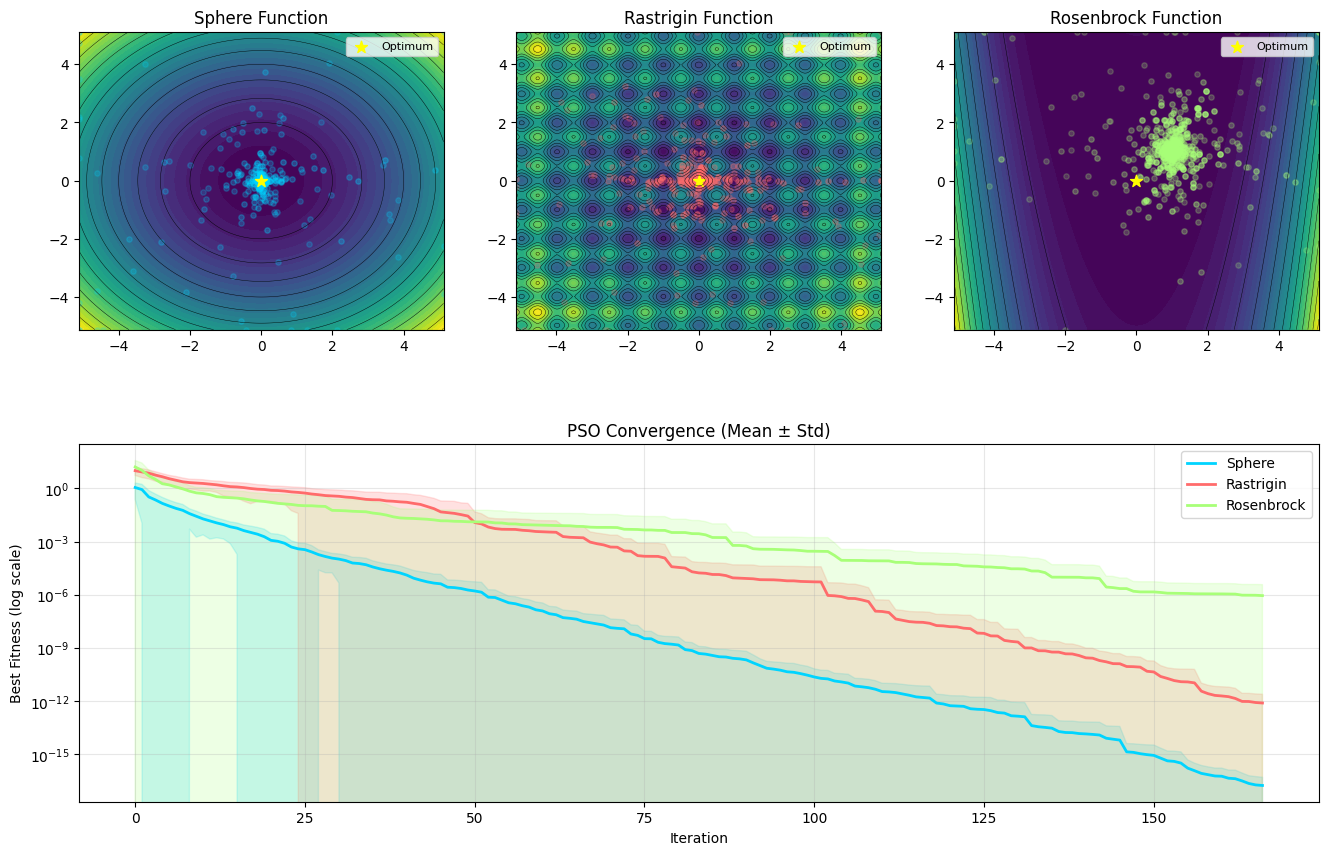

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from dataclasses import dataclass

@dataclass
class Config:
    dim: int = 2
    budget: int = 5_000
    pop_size: int = 30
    runs: int = 50   
    w: float = 0.729
    c1: float = 1.494
    c2: float = 1.494
    bounds: tuple = (-5.12, 5.12)

FUNCTIONS = {
    "Sphere":     lambda x: np.sum(x**2, axis=-1),
    "Rastrigin":  lambda x: 10*x.shape[-1] + np.sum(x**2 - 10*np.cos(2*np.pi*x), axis=-1),
    "Rosenbrock": lambda x: np.sum(100*(x[...,1:]-x[...,:-1]**2)**2 + (1-x[...,:-1])**2, axis=-1),
}

#  PSO 
def pso(func, cfg: Config, track_particles=False):
    lo, hi = cfg.bounds
    pos = np.random.uniform(lo, hi, (cfg.pop_size, cfg.dim))
    vel = np.random.uniform(-(hi-lo), hi-lo, (cfg.pop_size, cfg.dim))

    pbest = pos.copy()
    pbest_fit = func(pos)

    gbest = pbest[pbest_fit.argmin()].copy()
    gbest_fit = pbest_fit.min()

    history = [gbest_fit]
    snapshots = []

    evals = cfg.pop_size
    step = 0

    while evals < cfg.budget:
        r1, r2 = np.random.rand(2, cfg.pop_size, cfg.dim)

        vel = (cfg.w * vel
               + cfg.c1 * r1 * (pbest - pos)
               + cfg.c2 * r2 * (gbest - pos))

        pos = np.clip(pos + vel, lo, hi)
        fit = func(pos)
        evals += cfg.pop_size
        improved = fit < pbest_fit
        pbest[improved] = pos[improved]
        pbest_fit[improved] = fit[improved]
        if pbest_fit.min() < gbest_fit:
            gbest_fit = pbest_fit.min()
            gbest = pbest[pbest_fit.argmin()].copy()
        history.append(gbest_fit)
        if track_particles and step % 5 == 0:
            snapshots.append(pos.copy())
        step += 1
    return gbest_fit, history, snapshots

def make_grid(func, bounds, res=200):
    lo, hi = bounds
    x = np.linspace(lo, hi, res)
    X, Y = np.meshgrid(x, x)
    Z = func(np.stack([X, Y], axis=-1))
    return X, Y, Z

def master_plot(cfg: Config):
    np.random.seed(42)
    names = list(FUNCTIONS.keys())
    colors = ['#00d4ff', '#ff6b6b', '#a8ff78']
    fig = plt.figure(figsize=(16, 10))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 1.2], hspace=0.35)
    # row 1landsc + swarm
    for i, (name, color) in enumerate(zip(names, colors)):
        ax = fig.add_subplot(gs[0, i])
        func = FUNCTIONS[name]
        X, Y, Z = make_grid(func, cfg.bounds)
        ax.contourf(X, Y, Z, levels=40, cmap='viridis')
        ax.contour(X, Y, Z, levels=15, colors='black', linewidths=0.3)
        _, _, snapshots = pso(func, cfg, track_particles=True)
        for j, snap in enumerate(snapshots):
            alpha = 0.2 + 0.6 * (j / len(snapshots))
            ax.scatter(snap[:, 0], snap[:, 1],
                       s=15, color=color, alpha=alpha)
        ax.scatter(0, 0, color='yellow', s=80, marker='*', label='Optimum')
        ax.set_title(f"{name} Function")
        ax.set_xlim(cfg.bounds)
        ax.set_ylim(cfg.bounds)
        ax.legend(fontsize=8)

    # row 2 convergence 
    ax = fig.add_subplot(gs[1, :])

    for name, color in zip(names, colors):
        func = FUNCTIONS[name]
        curves = []
        for _ in range(cfg.runs):
            _, hist, _ = pso(func, cfg)
            curves.append(hist)
        min_len = min(len(c) for c in curves)
        curves = np.array([c[:min_len] for c in curves])
        mean = curves.mean(axis=0)
        std = curves.std(axis=0)
        ax.plot(mean, label=name, color=color, linewidth=2)
        # Std shading
        ax.fill_between(range(min_len),
                        mean - std,
                        mean + std,
                        color=color,
                        alpha=0.2)

    ax.set_yscale('log')
    ax.set_title("PSO Convergence (Mean ± Std)")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Best Fitness (log scale)")
    ax.legend()
    ax.grid(alpha=0.3)

    plt.show()


if __name__ == "__main__":
    master_plot(Config())